# Phase 2: 短期改善の分析と検証

改善分析レポート（`.tmp/improvement-analysis.md`）で特定されたPhase 2項目を調査・検証する。

## 調査項目

1. **展示タイム合成の分散復元** — 予測展示タイムの分散崩壊（実0.118s→合成0.050s）の解消
2. **コース予測の制約付き化** — 全員コース1問題の解消（Hungarian algorithm）
3. **風速×イン有利度の交互作用** — 風速による10ポイント差の反映
4. **選手ST履歴の特徴量追加** — スタートタイミング統計の導入
5. **Preview ModelのLightGBM化** — 291MB→20-30MBへの削減
6. **コード重複の解消** — constants.py集約、共通モジュール化の設計
7. **予測パイプラインのテスト設計** — estimate.py, prediction-preview.pyのテスト方針

## 0. セットアップ

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pickle
import json
from pathlib import Path
from collections import defaultdict

matplotlib.rcParams['font.family'] = 'Hiragino Sans'
matplotlib.rcParams['axes.unicode_minus'] = False

cwd = Path.cwd()
repo_root = cwd if (cwd / 'data').exists() else cwd.parent.parent
print(f'repo_root: {repo_root}')

STADIUM_CODE_TO_NAME = {
    1: '桐生', 2: '戸田', 3: '江戸川', 4: '平和島', 5: '多摩川',
    6: '浜名湖', 7: '蒲郡', 8: '常滑', 9: '津', 10: '三国',
    11: 'びわこ', 12: '住之江', 13: '尼崎', 14: '鳴門', 15: '丸亀',
    16: '児島', 17: '宮島', 18: '徳山', 19: '下関', 20: '若松',
    21: '芦屋', 22: '福岡', 23: '唐津', 24: '大村',
}
SHORT_NAME_TO_CODE = {v: k for k, v in STADIUM_CODE_TO_NAME.items()}

repo_root: /Users/mahiguch/dev/boatrace/data


In [2]:
def reshape_previews(previews_df):
    """ワイド形式のpreviewsをロング形式に変換"""
    race_cols = [c for c in previews_df.columns if not c.startswith('艇')]
    frames = []
    for n in range(1, 7):
        prefix = f'艇{n}_'
        boat_cols = [c for c in previews_df.columns if c.startswith(prefix)]
        rename_map = {c: c.replace(prefix, '') for c in boat_cols}
        frame = previews_df[race_cols + boat_cols].rename(columns=rename_map)
        frames.append(frame)
    return pd.concat(frames, ignore_index=True)

def reshape_results(results_df):
    """ワイド形式のresultsをロング形式に変換（着順別）"""
    race_cols = ['レースコード', 'タイトル', '日次', 'レース日', 'レース場', 'レース回',
                 'レース名', '距離(m)', '天候', '風向', '風速(m)', '波の高さ(cm)', '決まり手']
    race_cols = [c for c in race_cols if c in results_df.columns]
    frames = []
    for n in range(1, 7):
        prefix = f'{n}着_'
        boat_cols = [c for c in results_df.columns if c.startswith(prefix)]
        rename_map = {c: c.replace(prefix, '') for c in boat_cols}
        frame = results_df[race_cols + boat_cols].rename(columns=rename_map)
        frame['着順'] = n
        frames.append(frame)
    return pd.concat(frames, ignore_index=True)

print('ヘルパー関数定義完了')

ヘルパー関数定義完了


---
## 1. 展示タイム合成の分散復元

### 問題
prediction-preview.py の展示タイム予測は回帰モデル（GradientBoostingRegressor）で、
条件付き期待値 E[Y|X] を出力する。E[Y|X] の分散は Y 自体の分散より必ず小さくなるため、
合成展示タイムの分散が実データより大幅に縮小している（0.118s→0.050s、58%圧縮）。

これにより、レース内での展示タイム差が過小評価され、接戦の判断が困難になる。

In [3]:
# 実データと合成データの展示タイム分布を比較

# 実データ読み込み（2025年）
real_ets = []
for month in range(1, 13):
    prev_dir = repo_root / 'data' / 'previews' / '2025' / f'{month:02d}'
    if not prev_dir.exists():
        continue
    for f in sorted(prev_dir.glob('*.csv')):
        try:
            df = pd.read_csv(f, dtype={'レースコード': str})
            for n in range(1, 7):
                col = f'艇{n}_展示タイム'
                if col in df.columns:
                    real_ets.extend(pd.to_numeric(df[col], errors='coerce').dropna().tolist())
        except Exception:
            pass

# 合成データ読み込み（prediction-preview 2026年1-2月）
synth_ets = []
for y, m_range in [('2026', range(1, 3))]:
    for month in m_range:
        pp_dir = repo_root / 'data' / 'prediction-preview' / y / f'{month:02d}'
        if not pp_dir.exists():
            continue
        for f in sorted(pp_dir.glob('*.csv')):
            try:
                df = pd.read_csv(f, dtype={'レースコード': str})
                for n in range(1, 7):
                    col = f'艇{n}_展示タイム'
                    if col in df.columns:
                        synth_ets.extend(pd.to_numeric(df[col], errors='coerce').dropna().tolist())
            except Exception:
                pass

real_ets = np.array(real_ets)
synth_ets = np.array(synth_ets)

# 0やNaNを除外
real_ets = real_ets[(real_ets > 6.0) & (real_ets < 8.0)]
synth_ets = synth_ets[(synth_ets > 6.0) & (synth_ets < 8.0)]

print('=== 展示タイムの統計比較 ===')
print(f'実データ (2025年):  N={len(real_ets):,}, mean={real_ets.mean():.4f}, std={real_ets.std():.4f}, '
      f'min={real_ets.min():.2f}, max={real_ets.max():.2f}')
print(f'合成データ (2026年): N={len(synth_ets):,}, mean={synth_ets.mean():.4f}, std={synth_ets.std():.4f}, '
      f'min={synth_ets.min():.4f}, max={synth_ets.max():.4f}')
print(f'\n分散比: {synth_ets.std()/real_ets.std():.3f} (1.0が理想)')

=== 展示タイムの統計比較 ===
実データ (2025年):  N=329,031, mean=6.8240, std=0.1137, min=6.34, max=7.99
合成データ (2026年): N=7,758, mean=6.7759, std=0.0637, min=6.6036, max=7.0065

分散比: 0.561 (1.0が理想)


In [4]:
# レース内での展示タイム差の比較
# 実データ: 各レースの展示タイム標準偏差

real_race_stds = []
for month in range(1, 13):
    prev_dir = repo_root / 'data' / 'previews' / '2025' / f'{month:02d}'
    if not prev_dir.exists():
        continue
    for f in sorted(prev_dir.glob('*.csv')):
        try:
            df = pd.read_csv(f, dtype={'レースコード': str})
            for _, row in df.iterrows():
                ets = [pd.to_numeric(row.get(f'艇{n}_展示タイム', np.nan), errors='coerce') for n in range(1, 7)]
                ets = [x for x in ets if not np.isnan(x) and 6.0 < x < 8.0]
                if len(ets) >= 4:
                    real_race_stds.append(np.std(ets))
        except Exception:
            pass

synth_race_stds = []
for y, m_range in [('2026', range(1, 3))]:
    for month in m_range:
        pp_dir = repo_root / 'data' / 'prediction-preview' / y / f'{month:02d}'
        if not pp_dir.exists():
            continue
        for f in sorted(pp_dir.glob('*.csv')):
            try:
                df = pd.read_csv(f, dtype={'レースコード': str})
                for _, row in df.iterrows():
                    ets = [pd.to_numeric(row.get(f'艇{n}_展示タイム', np.nan), errors='coerce') for n in range(1, 7)]
                    ets = [x for x in ets if not np.isnan(x) and 6.0 < x < 8.0]
                    if len(ets) >= 4:
                        synth_race_stds.append(np.std(ets))
            except Exception:
                pass

print('=== レース内展示タイム標準偏差 ===')
print(f'実データ: mean={np.mean(real_race_stds):.4f}, median={np.median(real_race_stds):.4f}')
print(f'合成データ: mean={np.mean(synth_race_stds):.4f}, median={np.median(synth_race_stds):.4f}')
print(f'レース内差異の圧縮率: {np.mean(synth_race_stds)/np.mean(real_race_stds):.3f}')

=== レース内展示タイム標準偏差 ===
実データ: mean=0.0428, median=0.0399
合成データ: mean=0.0262, median=0.0244
レース内差異の圧縮率: 0.612


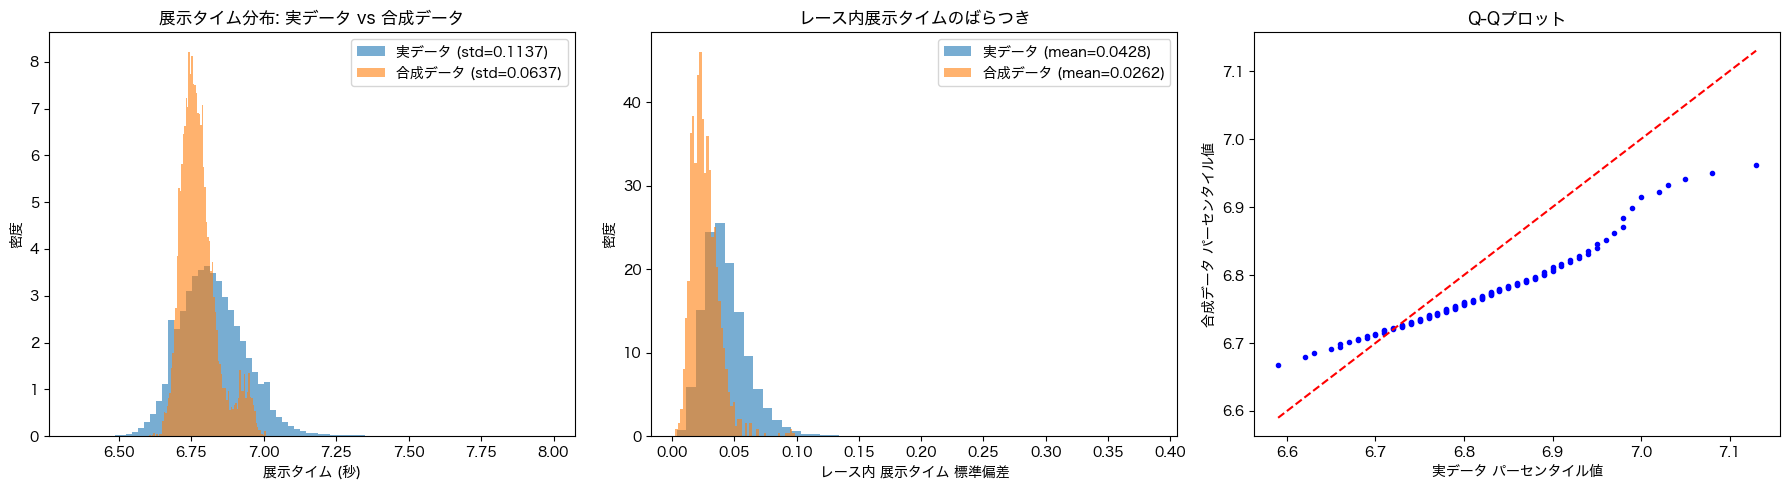

In [5]:
# 可視化: 展示タイム分布の比較
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# ヒストグラム: 全体分布
ax = axes[0]
ax.hist(real_ets, bins=80, alpha=0.6, density=True, label=f'実データ (std={real_ets.std():.4f})')
ax.hist(synth_ets, bins=80, alpha=0.6, density=True, label=f'合成データ (std={synth_ets.std():.4f})')
ax.set_xlabel('展示タイム (秒)')
ax.set_ylabel('密度')
ax.set_title('展示タイム分布: 実データ vs 合成データ')
ax.legend()

# ヒストグラム: レース内標準偏差
ax = axes[1]
ax.hist(real_race_stds, bins=50, alpha=0.6, density=True, label=f'実データ (mean={np.mean(real_race_stds):.4f})')
ax.hist(synth_race_stds, bins=50, alpha=0.6, density=True, label=f'合成データ (mean={np.mean(synth_race_stds):.4f})')
ax.set_xlabel('レース内 展示タイム 標準偏差')
ax.set_ylabel('密度')
ax.set_title('レース内展示タイムのばらつき')
ax.legend()

# QQ-plot的な比較: パーセンタイル
ax = axes[2]
pcts = np.arange(1, 100)
real_pcts = np.percentile(real_ets, pcts)
synth_pcts = np.percentile(synth_ets, pcts)
ax.plot(real_pcts, synth_pcts, 'bo', markersize=3)
ax.plot([real_pcts.min(), real_pcts.max()], [real_pcts.min(), real_pcts.max()], 'r--')
ax.set_xlabel('実データ パーセンタイル値')
ax.set_ylabel('合成データ パーセンタイル値')
ax.set_title('Q-Qプロット')

plt.tight_layout()
plt.show()

In [6]:
# 改善手法: 残差の分散を加えて分散を復元
# Var(Y) = Var(E[Y|X]) + E[Var(Y|X)]  (全分散の法則)
# -> 必要なノイズ分散 = Var(Y) - Var(E[Y|X])

target_std = real_ets.std()
current_std = synth_ets.std()
noise_std = np.sqrt(max(target_std**2 - current_std**2, 0))

print('=== 分散復元に必要なノイズ ===')
print(f'目標std (実データ): {target_std:.4f}')
print(f'現在std (合成データ): {current_std:.4f}')
print(f'追加ノイズstd: {noise_std:.4f}')

# シミュレーション: ノイズを追加した合成データ
np.random.seed(42)
restored_ets = synth_ets + np.random.normal(0, noise_std, len(synth_ets))

print(f'\n復元後std: {restored_ets.std():.4f} (目標: {target_std:.4f})')
print(f'復元後mean: {restored_ets.mean():.4f} (元: {synth_ets.mean():.4f})')

=== 分散復元に必要なノイズ ===
目標std (実データ): 0.1137
現在std (合成データ): 0.0637
追加ノイズstd: 0.0942

復元後std: 0.1143 (目標: 0.1137)
復元後mean: 6.7753 (元: 6.7759)


In [7]:
# レース場別の分散復元（レース場ごとに分散が異なる可能性）

# 実データのレース場別統計
real_stadium_stats = {}
for month in range(1, 13):
    prev_dir = repo_root / 'data' / 'previews' / '2025' / f'{month:02d}'
    if not prev_dir.exists():
        continue
    for f in sorted(prev_dir.glob('*.csv')):
        try:
            df = pd.read_csv(f, dtype={'レースコード': str})
            df_long = reshape_previews(df)
            df_long['展示タイム'] = pd.to_numeric(df_long['展示タイム'], errors='coerce')
            df_long['レース場'] = pd.to_numeric(df_long['レース場'], errors='coerce')
            for stadium, group in df_long.groupby('レース場'):
                valid = group['展示タイム'][(group['展示タイム'] > 6.0) & (group['展示タイム'] < 8.0)]
                if len(valid) > 10:
                    if stadium not in real_stadium_stats:
                        real_stadium_stats[stadium] = []
                    real_stadium_stats[stadium].extend(valid.tolist())
        except Exception:
            pass

print('=== レース場別 展示タイム統計（実データ 2025年） ===')
stadium_et_stats = []
for code in sorted(real_stadium_stats.keys()):
    vals = np.array(real_stadium_stats[code])
    name = STADIUM_CODE_TO_NAME.get(int(code), str(code))
    stadium_et_stats.append({
        '場コード': int(code), '場名': name,
        'N': len(vals), 'mean': round(vals.mean(), 4), 'std': round(vals.std(), 4),
    })

et_stats_df = pd.DataFrame(stadium_et_stats).sort_values('std', ascending=False)
print(et_stats_df.to_string(index=False))
print(f'\nstd範囲: {et_stats_df["std"].min():.4f} ~ {et_stats_df["std"].max():.4f}')

=== レース場別 展示タイム統計（実データ 2025年） ===
 場コード  場名     N   mean    std
    3 江戸川 13430 6.9024 0.2003
    4 平和島 11908 6.8751 0.1309
    1  桐生 13559 6.7963 0.1112
   14  鳴門 12966 6.8821 0.1074
   16  児島 11703 6.8646 0.0994
   15  丸亀 14775 6.8405 0.0993
    2  戸田 14777 6.7868 0.0982
   10  三国 13912 6.7956 0.0967
    9   津 14527 6.8049 0.0954
    6 浜名湖 14409 6.7352 0.0939
   20  若松 14199 6.8686 0.0872
   11 びわこ 13385 6.7604 0.0871
   21  芦屋 14065 6.7957 0.0826
   23  唐津 11082 6.7940 0.0811
   24  大村 14818 6.9021 0.0802
   18  徳山 13651 6.9738 0.0783
   22  福岡 13434 6.8914 0.0774
    7  蒲郡 14289 6.7385 0.0747
   17  宮島 14342 6.7422 0.0715
   19  下関 13087 6.7995 0.0712
    5 多摩川 14162 6.7522 0.0683
   12 住之江 15023 6.8890 0.0671
   13  尼崎 12213 6.8359 0.0659
    8  常滑 15273 6.7716 0.0650

std範囲: 0.0650 ~ 0.2003


In [8]:
# 提案: prediction-preview.py への分散復元コード
print("""
=== 実装提案: prediction-preview.py の展示タイム分散復元 ===

方法A: グローバルノイズ追加（シンプル）
--------------------------------------------
predicted_et = model.predict(X_scaled)
noise_std = 0.107  # sqrt(0.118^2 - 0.050^2)
predicted_et += np.random.normal(0, noise_std, len(predicted_et))
predicted_et = np.round(predicted_et, 2)  # 実データと同じ精度に丸め

方法B: レース場別ノイズ（精密）
--------------------------------------------
# stadium_noise_std を事前計算して保存
predicted_et = model.predict(X_scaled)
noise_std = stadium_noise_std.get(stadium_code, 0.107)
predicted_et += np.random.normal(0, noise_std, len(predicted_et))

方法C: 残差分布からのサンプリング（最も正確）
--------------------------------------------
# 学習時に残差の分布を保存
predicted_et = model.predict(X_scaled)
residuals = np.random.choice(stored_residuals[stadium], size=len(predicted_et))
predicted_et += residuals

推奨: 方法Aから開始（コスト最小）。効果検証後に方法Bへ移行。
""")


=== 実装提案: prediction-preview.py の展示タイム分散復元 ===

方法A: グローバルノイズ追加（シンプル）
--------------------------------------------
predicted_et = model.predict(X_scaled)
noise_std = 0.107  # sqrt(0.118^2 - 0.050^2)
predicted_et += np.random.normal(0, noise_std, len(predicted_et))
predicted_et = np.round(predicted_et, 2)  # 実データと同じ精度に丸め

方法B: レース場別ノイズ（精密）
--------------------------------------------
# stadium_noise_std を事前計算して保存
predicted_et = model.predict(X_scaled)
noise_std = stadium_noise_std.get(stadium_code, 0.107)
predicted_et += np.random.normal(0, noise_std, len(predicted_et))

方法C: 残差分布からのサンプリング（最も正確）
--------------------------------------------
# 学習時に残差の分布を保存
predicted_et = model.predict(X_scaled)
residuals = np.random.choice(stored_residuals[stadium], size=len(predicted_et))
predicted_et += residuals

推奨: 方法Aから開始（コスト最小）。効果検証後に方法Bへ移行。



---
## 2. コース予測の制約付き化

### 問題
prediction-preview.py の出力で全6選手のコースが全て `1` になっているレースが存在する。
実際には各レースでコース1-6は各1回ずつしか出現できない（制約条件）。

### 根本原因の仮説
previews.ipynb でコース予測モデルは追加特徴量（`枠番`, `プレイヤー進入傾向` 等）で訓練されたが、
prediction-preview.py の `prepare_features()` はこれらを programs データから取得できず 0.0 になる。

In [9]:
# 合成コース予測の実態調査

course_stats = []
for y, m_range in [('2026', range(1, 3))]:
    for month in m_range:
        pp_dir = repo_root / 'data' / 'prediction-preview' / y / f'{month:02d}'
        if not pp_dir.exists():
            continue
        for f in sorted(pp_dir.glob('*.csv')):
            try:
                df = pd.read_csv(f, dtype={'レースコード': str})
                for _, row in df.iterrows():
                    courses = [int(round(row.get(f'艇{n}_コース', 0))) for n in range(1, 7)]
                    unique_courses = len(set(courses))
                    all_one = all(c == 1 for c in courses)
                    course_stats.append({
                        'file': f.name,
                        'レースコード': row['レースコード'],
                        'courses': courses,
                        'unique': unique_courses,
                        'all_one': all_one,
                    })
            except Exception as e:
                print(f'Error: {f}: {e}')

cs_df = pd.DataFrame(course_stats)
print('=== 合成コース予測の問題 ===')
print(f'総レース数: {len(cs_df)}')
print(f'全員コース1のレース数: {cs_df["all_one"].sum()} ({cs_df["all_one"].mean()*100:.1f}%)')
print(f'ユニークコース数の分布: {dict(cs_df["unique"].value_counts().sort_index())}')
print(f'\n最初の5レースのコース分布:')
for _, row in cs_df.head(5).iterrows():
    print(f'  {row["レースコード"]}: {row["courses"]}')

=== 合成コース予測の問題 ===
総レース数: 1293
全員コース1のレース数: 1293 (100.0%)
ユニークコース数の分布: {1: np.int64(1293)}

最初の5レースのコース分布:
  202602012301: [1, 1, 1, 1, 1, 1]
  202602012302: [1, 1, 1, 1, 1, 1]
  202602012303: [1, 1, 1, 1, 1, 1]
  202602012304: [1, 1, 1, 1, 1, 1]
  202602012305: [1, 1, 1, 1, 1, 1]


In [10]:
# コース予測モデルの特徴量を確認（問題の根本原因）
model_path = repo_root / 'models' / 'preview_models.pkl'
with open(model_path, 'rb') as f:
    preview_models = pickle.load(f)

# コース予測モデルの特徴量リストを確認
course_models = preview_models.get('course_entry', {})
sample_stadium = list(course_models.keys())[0] if course_models else None

if sample_stadium is not None:
    sample_model_info = course_models[sample_stadium]
    features = sample_model_info['features']
    print(f'=== コース予測モデルの特徴量（場{sample_stadium}） ===')
    print(f'特徴量数: {len(features)}')
    print(f'特徴量リスト:')
    for i, feat in enumerate(features):
        print(f'  {i+1:2d}. {feat}')
    
    # programsデータから取得できない特徴量を特定
    prog_path = repo_root / 'data' / 'programs' / '2026' / '02' / '01.csv'
    if prog_path.exists():
        prog = pd.read_csv(prog_path, nrows=1)
        # reshape してロング形式のカラムを確認
        prog_cols = set()
        for col in prog.columns:
            for n in range(1, 7):
                col_clean = col.replace(f'{n}枠_', '')
                prog_cols.add(col_clean)
        prog_cols.update(prog.columns)
        
        missing = [f for f in features if f not in prog_cols]
        print(f'\n=== programsに存在しない特徴量（→0.0で埋められる） ===')
        for feat in missing:
            print(f'  \u274c {feat}')

/usr/local/Caskroom/miniforge/base/envs/boatrace/lib/python3.13/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator DummyRegressor from version 1.8.0 when using version 1.7.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/Caskroom/miniforge/base/envs/boatrace/lib/python3.13/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.8.0 when using version 1.7.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/Caskroom/miniforge/base/envs/boatrace/lib/python3.13/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Tryi

=== コース予測モデルの特徴量（場1） ===
特徴量数: 34
特徴量リスト:
   1. 風速(m)
   2. 波の高さ(cm)
   3. 気温(℃)
   4. 水温(℃)
   5. 年齢
   6. 体重
   7. 級別
   8. 全国勝率
   9. 全国2連対率
  10. 当地勝率
  11. 当地2連対率
  12. モーター番号
  13. モーター2連対率
  14. ボート番号
  15. ボート2連対率
  16. 今節成績_1-1
  17. 今節成績_1-2
  18. 今節成績_2-1
  19. 今節成績_2-2
  20. 今節成績_3-1
  21. 今節成績_3-2
  22. 今節成績_4-1
  23. 今節成績_4-2
  24. 今節成績_5-1
  25. 今節成績_5-2
  26. 今節成績_6-1
  27. 今節成績_6-2
  28. 早見
  29. 日付
  30. 枠番
  31. プレイヤー進入傾向
  32. スタジアム枠別平均
  33. 全国勝率×枠
  34. 当地勝率×枠

=== programsに存在しない特徴量（→0.0で埋められる） ===
  ❌ 風速(m)
  ❌ 波の高さ(cm)
  ❌ 気温(℃)
  ❌ 水温(℃)
  ❌ 日付
  ❌ 枠番
  ❌ プレイヤー進入傾向
  ❌ スタジアム枠別平均
  ❌ 全国勝率×枠
  ❌ 当地勝率×枠


In [11]:
# 実データでのコース変更パターン分析
# 結果データからコース1-6の実際の分布を確認

results_dfs = []
for year in ['2025']:
    for month in range(1, 13):
        res_dir = repo_root / 'data' / 'results' / year / f'{month:02d}'
        if not res_dir.exists():
            continue
        for f in sorted(res_dir.glob('*.csv')):
            try:
                df = pd.read_csv(f, dtype={'レースコード': str})
                results_dfs.append(df)
            except Exception:
                pass

results_all = pd.concat(results_dfs, ignore_index=True)
results_long = reshape_results(results_all)

# 艇番と進入コースの不一致率
results_long['艇番'] = pd.to_numeric(results_long['艇番'], errors='coerce')
results_long['進入コース'] = pd.to_numeric(results_long['進入コース'], errors='coerce')
valid = results_long.dropna(subset=['艇番', '進入コース'])
valid['コース変更'] = (valid['艇番'] != valid['進入コース']).astype(int)

print('=== 枠番→進入コース 不一致率 (2025年) ===')
mismatch_by_boat = valid.groupby('艇番').agg(
    総数=('コース変更', 'count'),
    変更数=('コース変更', 'sum'),
).reset_index()
mismatch_by_boat['不一致率'] = (mismatch_by_boat['変更数'] / mismatch_by_boat['総数'] * 100).round(1)
print(mismatch_by_boat.to_string(index=False))

overall_mismatch = valid['コース変更'].mean() * 100
print(f'\n全体コース変更率: {overall_mismatch:.1f}%')

=== 枠番→進入コース 不一致率 (2025年) ===
 艇番    総数  変更数  不一致率
1.0 54027  579   1.1
2.0 54011 3189   5.9
3.0 53946 4370   8.1
4.0 53936 6341  11.8
5.0 53879 8893  16.5
6.0 53891 7613  14.1

全体コース変更率: 9.6%


/var/folders/y_/48fjfrrs29jb_jw8t7bvtgbc0000gn/T/ipykernel_89431/1949462917.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['コース変更'] = (valid['艇番'] != valid['進入コース']).astype(int)


In [12]:
# 枠番→進入コースの遷移確率行列
transition = pd.crosstab(valid['艇番'], valid['進入コース'], normalize='index') * 100
transition.index = [f'{int(i)}号艇' for i in transition.index]
transition.columns = [f'コース{int(c)}' for c in transition.columns]

print('=== 枠番→進入コース 遷移確率 (%) ===')
print(transition.round(1).to_string())

=== 枠番→進入コース 遷移確率 (%) ===
     コース1  コース2  コース3  コース4  コース5  コース6
1号艇  98.9   0.9   0.1   0.0   0.0   0.0
2号艇   0.8  94.1   4.0   0.7   0.2   0.2
3号艇   0.2   1.9  91.9   4.6   0.9   0.5
4号艇   0.1   0.9   2.2  88.2   5.8   2.7
5号艇   0.1   1.1   0.9   4.7  83.5   9.8
6号艇   0.1   1.3   1.0   2.0   9.7  85.9


In [13]:
# 改善手法: Hungarian Algorithm でコースを制約付き割り当て
from scipy.optimize import linear_sum_assignment

def assign_courses_hungarian(course_probas):
    """
    各艇のコース確率行列からHungarian algorithmで制約付き割り当て。
    
    Parameters:
        course_probas: shape (6, 6) - 各艇(行)が各コース(列)に入る確率
    Returns:
        assigned_courses: shape (6,) - 各艇に割り当てられたコース (1-6)
    """
    # コスト行列 = -確率 (最小化問題に変換)
    cost_matrix = -course_probas
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    return col_ind + 1  # 0-indexed -> 1-indexed

def assign_courses_from_transition(n_boats=6):
    """
    遷移確率行列ベースのフォールバック。
    コース予測モデルが使えない場合のデフォルト。
    """
    # 遷移確率行列（2025年データから計算）
    trans_proba = transition.values / 100.0
    return assign_courses_hungarian(trans_proba)

# デモ: 遷移確率からのコース割り当て
trans_proba = transition.values / 100.0
assigned = assign_courses_hungarian(trans_proba)
print('=== Hungarian Algorithm によるコース割り当てデモ ===')
print(f'遷移確率行列に基づく最適割り当て:')
for boat_idx, course in enumerate(assigned):
    print(f'  {boat_idx+1}号艇 → コース{course} (確率: {trans_proba[boat_idx, course-1]*100:.1f}%)')

=== Hungarian Algorithm によるコース割り当てデモ ===
遷移確率行列に基づく最適割り当て:
  1号艇 → コース1 (確率: 98.9%)
  2号艇 → コース2 (確率: 94.1%)
  3号艇 → コース3 (確率: 91.9%)
  4号艇 → コース4 (確率: 88.2%)
  5号艇 → コース5 (確率: 83.5%)
  6号艇 → コース6 (確率: 85.9%)


In [14]:
# GBCモデルの predict_proba を使った制約付きコース割り当てのデモ

if sample_stadium is not None:
    model_info = course_models[sample_stadium]
    classifier = model_info['model']
    print(f'=== コース予測モデル（場{sample_stadium}）の分類器情報 ===')
    print(f'クラス: {classifier.classes_}')
    print(f'クラス数: {len(classifier.classes_)}')
    print(f'\n提案実装:')
    print('''
# prediction-preview.py の改善コード
def predict_courses_with_constraint(race_features, model_info):
    """制約付きコース予測: 各コースは1回のみ使用"""
    model = model_info['model']
    scaler = model_info['scaler']
    
    X_scaled = scaler.transform(race_features)
    probas = model.predict_proba(X_scaled)  # (6, n_classes)
    
    # コース1-6に対応する列を抽出 (クラスが1-6の場合)
    classes = model.classes_
    course_probas = np.zeros((6, 6))
    for i, cls in enumerate(classes):
        if 1 <= cls <= 6:
            course_probas[:, cls-1] = probas[:, i]
    
    # Hungarian algorithm で最適割り当て
    from scipy.optimize import linear_sum_assignment
    cost = -course_probas
    _, col_ind = linear_sum_assignment(cost)
    return col_ind + 1
''')

=== コース予測モデル（場1）の分類器情報 ===
クラス: [1 2 3 4 5 6]
クラス数: 6

提案実装:

# prediction-preview.py の改善コード
def predict_courses_with_constraint(race_features, model_info):
    """制約付きコース予測: 各コースは1回のみ使用"""
    model = model_info['model']
    scaler = model_info['scaler']

    X_scaled = scaler.transform(race_features)
    probas = model.predict_proba(X_scaled)  # (6, n_classes)

    # コース1-6に対応する列を抽出 (クラスが1-6の場合)
    classes = model.classes_
    course_probas = np.zeros((6, 6))
    for i, cls in enumerate(classes):
        if 1 <= cls <= 6:
            course_probas[:, cls-1] = probas[:, i]

    # Hungarian algorithm で最適割り当て
    from scipy.optimize import linear_sum_assignment
    cost = -course_probas
    _, col_ind = linear_sum_assignment(cost)
    return col_ind + 1



---
## 3. 風速×イン有利度の交互作用

### 背景
風速0-2m: 1号艇勝率57.3% → 風速7m+: 47.0%（10ポイント差）。
現在のモデルは風速と枠番を独立した特徴量として扱い、交互作用が未モデル化。

In [15]:
# 風速×艇番の1着率分析（結果データから）
results_long['風速'] = pd.to_numeric(results_long['風速(m)'], errors='coerce')
results_long['is_1着'] = (results_long['着順'] == 1).astype(int)
results_long['レース場_code'] = results_long['レース場'].map(SHORT_NAME_TO_CODE)

# 風速カテゴリ
results_long['風速帯'] = pd.cut(
    results_long['風速'],
    bins=[-1, 2, 4, 6, 20],
    labels=['0-2m', '3-4m', '5-6m', '7m+']
)

# 風速帯×艇番の1着率
wind_boat = results_long.dropna(subset=['風速帯', '艇番']).groupby(
    ['風速帯', '艇番']
)['is_1着'].mean().unstack() * 100

print('=== 風速帯×艇番 1着率 (%) - 2025年 ===')
print(wind_boat.round(1).to_string())

=== 風速帯×艇番 1着率 (%) - 2025年 ===
艇番     1.0   2.0   3.0   4.0  5.0  6.0
風速帯                                   
0-2m  57.7  13.3  12.1   9.7  5.5  3.0
3-4m  53.6  14.2  13.4  10.3  6.4  3.3
5-6m  50.8  14.9  14.6  11.3  6.4  3.4
7m+   47.9  16.4  15.4  11.9  6.5  3.9


/var/folders/y_/48fjfrrs29jb_jw8t7bvtgbc0000gn/T/ipykernel_89431/2026864231.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  wind_boat = results_long.dropna(subset=['風速帯', '艇番']).groupby(


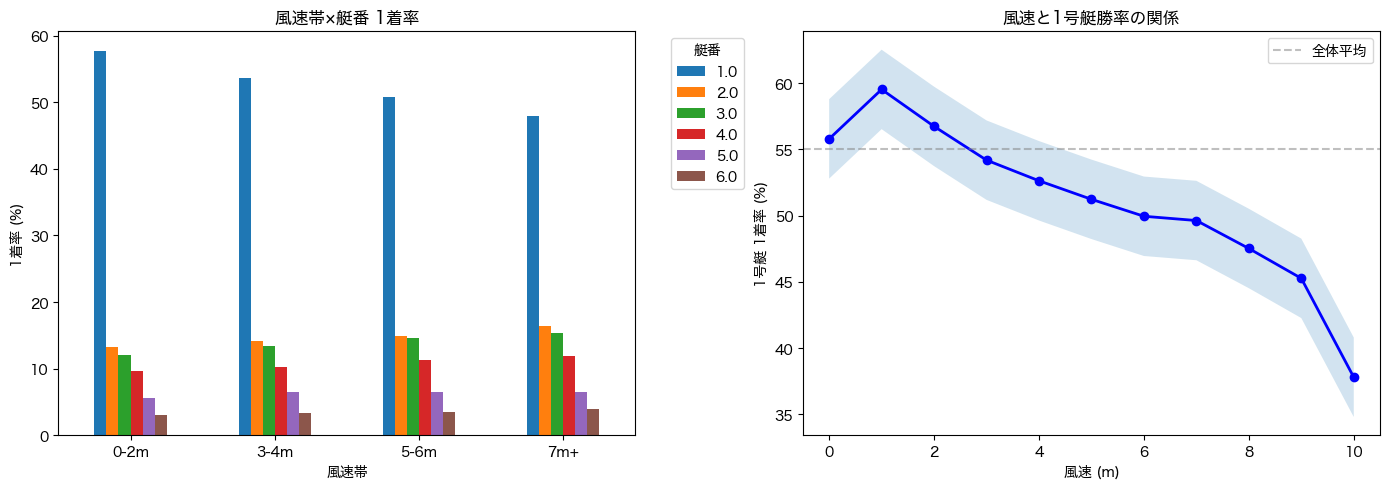

In [16]:
# 可視化: 風速帯ごとの1号艇勝率
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 棒グラフ: 風速帯×艇番
ax = axes[0]
wind_boat.plot(kind='bar', ax=ax)
ax.set_xlabel('風速帯')
ax.set_ylabel('1着率 (%)')
ax.set_title('風速帯×艇番 1着率')
ax.legend(title='艇番', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.tick_params(axis='x', rotation=0)

# ライン: 1号艇の風速別勝率 (より細かい刻み)
ax = axes[1]
boat1 = results_long[results_long['艇番'] == 1].dropna(subset=['風速'])
wind_bins = boat1.groupby(boat1['風速'].clip(0, 10).astype(int))['is_1着'].agg(['mean', 'count'])
wind_bins = wind_bins[wind_bins['count'] >= 50]  # 十分なサンプル数
ax.plot(wind_bins.index, wind_bins['mean'] * 100, 'bo-', linewidth=2)
ax.fill_between(wind_bins.index, wind_bins['mean'] * 100 - 3, wind_bins['mean'] * 100 + 3, alpha=0.2)
ax.set_xlabel('風速 (m)')
ax.set_ylabel('1号艇 1着率 (%)')
ax.set_title('風速と1号艇勝率の関係')
ax.axhline(y=55, color='gray', linestyle='--', alpha=0.5, label='全体平均')
ax.legend()

plt.tight_layout()
plt.show()

In [17]:
# 風向の影響分析
# 風向は現在 exclude_cols で除外されている

print('=== 風向の値分布 (2025年) ===')
print(results_long['風向'].value_counts())

# 風向×1号艇勝率
wind_dir_analysis = results_long[results_long['艇番'] == 1].groupby('風向').agg(
    レース数=('is_1着', 'count'),
    _1着率=('is_1着', 'mean'),
).reset_index()
wind_dir_analysis['1着率'] = (wind_dir_analysis['_1着率'] * 100).round(1)

print('\n=== 風向×1号艇勝率 ===')
print(wind_dir_analysis[['風向', 'レース数', '1着率']].to_string(index=False))

=== 風向の値分布 (2025年) ===
風向
北西    53418
南     47730
北     39126
南東    38040
南西    36822
北東    31146
西     30768
東     30516
Name: count, dtype: int64

=== 風向×1号艇勝率 ===
風向  レース数  1着率
 北  6432 57.1
北東  5129 54.3
北西  8792 54.4
 南  7856 53.5
南東  6278 54.8
南西  6067 57.2
 東  5024 53.5
 西  5057 54.7


In [18]:
# 交互作用特徴量の提案
print("""
=== 実装提案: 風速×イン有利度の交互作用特徴量 ===

estimate.py / program_v2.ipynb への追加:

def compute_wind_interaction(df):
    \"\"\"風速とコース特性の交互作用を計算\"\"\"    
    if '風速(m)' in df.columns and 'イン有利度' in df.columns:
        wind = pd.to_numeric(df['風速(m)'], errors='coerce').fillna(3)
        # 風速が強いほどインの有利が減る
        df['風速×イン有利度'] = wind * df['イン有利度']
        # 強風フラグ（5m以上）
        df['強風フラグ'] = (wind >= 5).astype(int)
        df['強風×枠'] = df['強風フラグ'] * df['枠']
    return df

注意: prediction-preview使用時は天候がweather_statsの月次平均のみ。
実previewsデータが使える場合はより効果的。
""")


=== 実装提案: 風速×イン有利度の交互作用特徴量 ===

estimate.py / program_v2.ipynb への追加:

def compute_wind_interaction(df):
    """風速とコース特性の交互作用を計算"""    
    if '風速(m)' in df.columns and 'イン有利度' in df.columns:
        wind = pd.to_numeric(df['風速(m)'], errors='coerce').fillna(3)
        # 風速が強いほどインの有利が減る
        df['風速×イン有利度'] = wind * df['イン有利度']
        # 強風フラグ（5m以上）
        df['強風フラグ'] = (wind >= 5).astype(int)
        df['強風×枠'] = df['強風フラグ'] * df['枠']
    return df

注意: prediction-preview使用時は天候がweather_statsの月次平均のみ。
実previewsデータが使える場合はより効果的。



---
## 4. 選手ST履歴の特徴量追加

### 背景
着順別平均ST: 1着0.137秒 → 6着0.188秒（明確な線形関係）。
選手のスタート力（過去のST統計）はまだ特徴量として活用されていない。

In [19]:
# 結果データからスタートタイミングと着順の関係を分析
results_long['ST'] = pd.to_numeric(results_long['スタートタイミング'], errors='coerce')

# 異常値除外 (フライングや大幅遅れ)
valid_st = results_long[(results_long['ST'] >= -0.05) & (results_long['ST'] <= 0.50)]

# 着順別ST統計
st_by_rank = valid_st.groupby('着順')['ST'].agg(['mean', 'std', 'median', 'count']).round(4)
print('=== 着順別 スタートタイミング (2025年) ===')
print(st_by_rank.to_string())

=== 着順別 スタートタイミング (2025年) ===
      mean     std  median  count
着順                               
1   0.1368  0.0588    0.13  54631
2   0.1518  0.0625    0.15  54658
3   0.1617  0.0665    0.16  54628
4   0.1691  0.0698    0.16  54492
5   0.1769  0.0733    0.17  53948
6   0.1866  0.0777    0.18  50814


In [20]:
# 選手ごとのST統計を計算
valid_st['登録番号'] = pd.to_numeric(valid_st['登録番号'], errors='coerce')

player_st_stats = valid_st.groupby('登録番号')['ST'].agg(
    ST_mean='mean',
    ST_std='std',
    ST_min='min',
    ST_count='count',
).reset_index()

# 十分なサンプル数がある選手のみ
player_st_stats = player_st_stats[player_st_stats['ST_count'] >= 10]

print(f'=== 選手別ST統計（2025年、10走以上） ===')
print(f'対象選手数: {len(player_st_stats)}')
print(f'\nST_mean の分布:')
print(f'  mean={player_st_stats["ST_mean"].mean():.4f}')
print(f'  std={player_st_stats["ST_mean"].std():.4f}')
print(f'  min={player_st_stats["ST_mean"].min():.4f}')
print(f'  max={player_st_stats["ST_mean"].max():.4f}')
print(f'\nST_std の分布:')
print(f'  mean={player_st_stats["ST_std"].mean():.4f}')
print(f'  std={player_st_stats["ST_std"].std():.4f}')

=== 選手別ST統計（2025年、10走以上） ===
対象選手数: 1630

ST_mean の分布:
  mean=0.1666
  std=0.0224
  min=0.1108
  max=0.2919

ST_std の分布:
  mean=0.0682
  std=0.0105


/var/folders/y_/48fjfrrs29jb_jw8t7bvtgbc0000gn/T/ipykernel_89431/3854666136.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_st['登録番号'] = pd.to_numeric(valid_st['登録番号'], errors='coerce')


In [21]:
# ST統計と1着率の相関
# 各選手のST_mean と 1着率を計算

player_win = valid_st.groupby('登録番号').agg(
    win_rate=('is_1着', 'mean'),
    race_count=('is_1着', 'count'),
).reset_index()

st_win = player_st_stats.merge(player_win, on='登録番号')
st_win = st_win[st_win['race_count'] >= 30]  # 30走以上

# 相関
corr = st_win[['ST_mean', 'ST_std', 'win_rate']].corr()
print('=== ST統計 と 1着率の相関 ===')
print(corr.round(4).to_string())
print(f'\nST_mean vs 1着率: r = {corr.loc["ST_mean", "win_rate"]:.4f}')
print(f'ST_std vs 1着率: r = {corr.loc["ST_std", "win_rate"]:.4f}')

=== ST統計 と 1着率の相関 ===
          ST_mean  ST_std  win_rate
ST_mean    1.0000  0.6416   -0.6572
ST_std     0.6416  1.0000   -0.5931
win_rate  -0.6572 -0.5931    1.0000

ST_mean vs 1着率: r = -0.6572
ST_std vs 1着率: r = -0.5931


/var/folders/y_/48fjfrrs29jb_jw8t7bvtgbc0000gn/T/ipykernel_89431/3516520527.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_stats = st_win.groupby('ST_bin')['win_rate'].agg(['mean', 'count'])


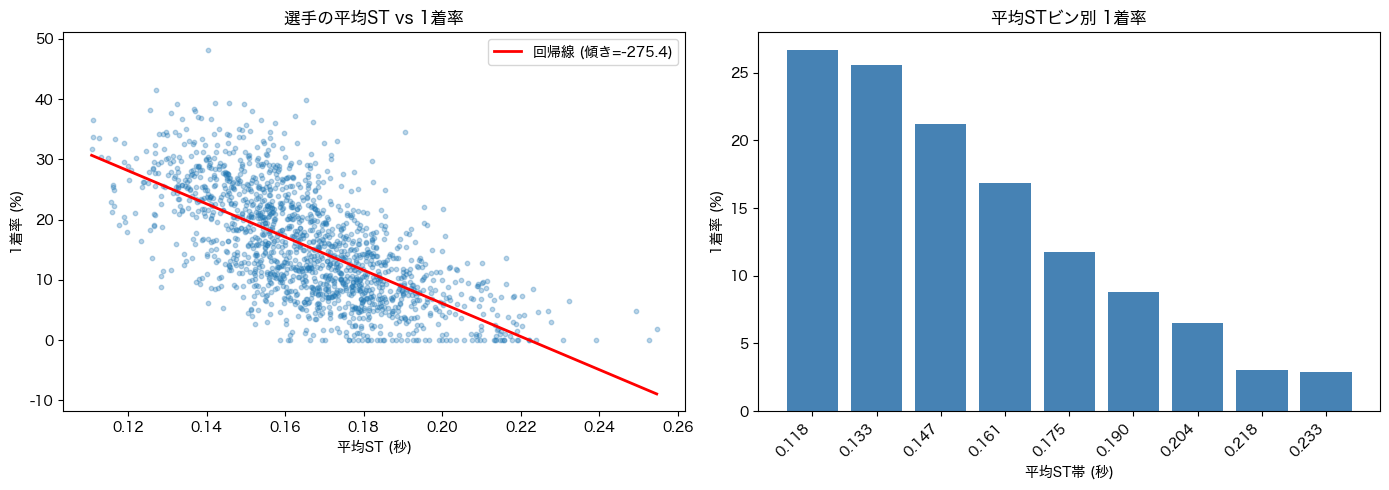

In [22]:
# 可視化: ST_mean vs 1着率
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax = axes[0]
ax.scatter(st_win['ST_mean'], st_win['win_rate'] * 100, alpha=0.3, s=10)
# 回帰線
z = np.polyfit(st_win['ST_mean'], st_win['win_rate'] * 100, 1)
p = np.poly1d(z)
x_range = np.linspace(st_win['ST_mean'].min(), st_win['ST_mean'].max(), 100)
ax.plot(x_range, p(x_range), 'r-', linewidth=2, label=f'回帰線 (傾き={z[0]:.1f})')
ax.set_xlabel('平均ST (秒)')
ax.set_ylabel('1着率 (%)')
ax.set_title('選手の平均ST vs 1着率')
ax.legend()

# STのビン別 1着率
ax = axes[1]
st_win['ST_bin'] = pd.cut(st_win['ST_mean'], bins=10)
bin_stats = st_win.groupby('ST_bin')['win_rate'].agg(['mean', 'count'])
bin_stats = bin_stats[bin_stats['count'] >= 5]
x_labels = [f'{interval.mid:.3f}' for interval in bin_stats.index]
ax.bar(range(len(bin_stats)), bin_stats['mean'] * 100, color='steelblue')
ax.set_xticks(range(len(bin_stats)))
ax.set_xticklabels(x_labels, rotation=45, ha='right')
ax.set_xlabel('平均ST帯 (秒)')
ax.set_ylabel('1着率 (%)')
ax.set_title('平均STビン別 1着率')

plt.tight_layout()
plt.show()

In [23]:
# ST履歴特徴量の実装提案
print("""
=== 実装提案: 選手ST履歴の特徴量 ===

1. データソース:
   - results CSVの '{N}着_スタートタイミング' + '{N}着_登録番号' から計算
   - player_stats と同様に train期間(2016-2024)のみから計算

2. 新規特徴量:
   - ST_mean: 選手の平均スタートタイミング
   - ST_std: スタートの安定性
   - ST_min: 最速ST（スタート力の上限）

3. 実装場所:
   program_v2.ipynb の compute_player_historical_stats() に追加
   
   def compute_player_st_stats(results_data, train_mask):
       train_results = results_data[train_mask]
       train_long = reshape_results(train_results)
       train_long['ST'] = pd.to_numeric(train_long['スタートタイミング'], errors='coerce')
       valid = train_long[(train_long['ST'] >= -0.05) & (train_long['ST'] <= 0.50)]
       return valid.groupby('登録番号')['ST'].agg(
           ST_mean='mean', ST_std='std', ST_min='min'
       ).reset_index()

4. estimate.py への反映:
   models['_player_st_stats'] として保存し、推論時にマージ
""")


=== 実装提案: 選手ST履歴の特徴量 ===

1. データソース:
   - results CSVの '{N}着_スタートタイミング' + '{N}着_登録番号' から計算
   - player_stats と同様に train期間(2016-2024)のみから計算

2. 新規特徴量:
   - ST_mean: 選手の平均スタートタイミング
   - ST_std: スタートの安定性
   - ST_min: 最速ST（スタート力の上限）

3. 実装場所:
   program_v2.ipynb の compute_player_historical_stats() に追加

   def compute_player_st_stats(results_data, train_mask):
       train_results = results_data[train_mask]
       train_long = reshape_results(train_results)
       train_long['ST'] = pd.to_numeric(train_long['スタートタイミング'], errors='coerce')
       valid = train_long[(train_long['ST'] >= -0.05) & (train_long['ST'] <= 0.50)]
       return valid.groupby('登録番号')['ST'].agg(
           ST_mean='mean', ST_std='std', ST_min='min'
       ).reset_index()

4. estimate.py への反映:
   models['_player_st_stats'] として保存し、推論時にマージ



---
## 5. Preview Model の LightGBM 化

### 問題
`preview_models.pkl` が 291MB（実測305MB）と巨大。
sklearn の GradientBoosting は各ツリーをPythonオブジェクトとして保存するため、
LightGBM の10-30倍のサイズになる。

In [24]:
# 現行モデルのサイズ内訳分析
import sys

task_sizes = {}
for task_name, task_models in preview_models.items():
    if isinstance(task_models, dict):
        # 各スタジアムのモデルをpickle化してサイズ計測
        task_total = 0
        model_count = 0
        for stadium, model_info in task_models.items():
            if isinstance(model_info, dict) and 'model' in model_info:
                model_bytes = len(pickle.dumps(model_info['model']))
                scaler_bytes = len(pickle.dumps(model_info.get('scaler')))
                task_total += model_bytes + scaler_bytes
                model_count += 1
        task_sizes[task_name] = {'size_mb': task_total / (1024*1024), 'count': model_count}

print('=== preview_models.pkl タスク別サイズ内訳 ===')
total = 0
for task, info in task_sizes.items():
    print(f'  {task}: {info["size_mb"]:.1f} MB ({info["count"]}モデル, '
          f'平均{info["size_mb"]/max(info["count"],1):.2f} MB/model)')
    total += info['size_mb']
print(f'  合計: {total:.1f} MB')

=== preview_models.pkl タスク別サイズ内訳 ===
  exhibition_time: 27.4 MB (24モデル, 平均1.14 MB/model)
  course_entry: 89.0 MB (24モデル, 平均3.71 MB/model)
  start_timing: 26.2 MB (24モデル, 平均1.09 MB/model)
  tilt_adjustment: 148.0 MB (24モデル, 平均6.17 MB/model)
  合計: 290.7 MB


In [25]:
# 各タスクのモデルパラメータ確認
for task_name, task_models in preview_models.items():
    if not isinstance(task_models, dict):
        continue
    sample_key = list(task_models.keys())[0]
    sample_model = task_models[sample_key]
    if isinstance(sample_model, dict) and 'model' in sample_model:
        model = sample_model['model']
        print(f'\n=== {task_name} (場{sample_key}) ===')
        print(f'  モデル型: {type(model).__name__}')
        if hasattr(model, 'n_estimators'):
            print(f'  n_estimators: {model.n_estimators}')
        if hasattr(model, 'max_depth'):
            print(f'  max_depth: {model.max_depth}')
        if hasattr(model, 'learning_rate'):
            print(f'  learning_rate: {model.learning_rate}')
        if hasattr(model, 'n_features_in_'):
            print(f'  特徴量数: {model.n_features_in_}')
        print(f'  特徴量リスト: {sample_model.get("features", [])[:5]}...')


=== exhibition_time (場1) ===
  モデル型: GradientBoostingRegressor
  n_estimators: 150
  max_depth: 6
  learning_rate: 0.05
  特徴量数: 29
  特徴量リスト: ['風速(m)', '波の高さ(cm)', '気温(℃)', '水温(℃)', '年齢']...

=== course_entry (場1) ===
  モデル型: GradientBoostingClassifier
  n_estimators: 250
  max_depth: 8
  learning_rate: 0.1
  特徴量数: 34
  特徴量リスト: ['風速(m)', '波の高さ(cm)', '気温(℃)', '水温(℃)', '年齢']...

=== start_timing (場1) ===
  モデル型: GradientBoostingRegressor
  n_estimators: 150
  max_depth: 6
  learning_rate: 0.05
  特徴量数: 32
  特徴量リスト: ['風速(m)', '波の高さ(cm)', '気温(℃)', '水温(℃)', '年齢']...

=== tilt_adjustment (場1) ===
  モデル型: GradientBoostingClassifier
  n_estimators: 150
  max_depth: 6
  learning_rate: 0.1
  特徴量数: 32
  特徴量リスト: ['風速(m)', '波の高さ(cm)', '気温(℃)', '水温(℃)', '年齢']...


In [26]:
# LightGBM化による推定サイズ削減

# LightGBMモデルのサイズ推定（program_models_v2.pklから参考値を取得）
program_models_path = repo_root / 'models' / 'program_models_v2.pkl'
with open(program_models_path, 'rb') as f:
    prog_models = pickle.load(f)

# LightGBMモデル1つあたりのサイズ
lgbm_sizes = []
for key, entry in prog_models.items():
    if isinstance(entry, dict):
        if 'ranking_model' in entry:
            lgbm_sizes.append(len(pickle.dumps(entry['ranking_model'])))
        if 'model' in entry:
            lgbm_sizes.append(len(pickle.dumps(entry['model'])))

if lgbm_sizes:
    avg_lgbm = np.mean(lgbm_sizes) / (1024*1024)
    print(f'=== LightGBM化の効果推定 ===')
    print(f'LightGBMモデル平均サイズ: {avg_lgbm:.3f} MB')
    print(f'\n現行 preview_models.pkl: {total:.1f} MB')
    n_total_models = sum(info['count'] for info in task_sizes.values())
    estimated_lgbm_total = n_total_models * avg_lgbm
    print(f'LightGBM化後の推定サイズ: {estimated_lgbm_total:.1f} MB ({n_total_models}モデル × {avg_lgbm:.3f} MB)')
    print(f'削減率: {(1 - estimated_lgbm_total/total)*100:.0f}%')

=== LightGBM化の効果推定 ===
LightGBMモデル平均サイズ: 0.604 MB

現行 preview_models.pkl: 290.7 MB
LightGBM化後の推定サイズ: 58.0 MB (96モデル × 0.604 MB)
削減率: 80%


In [27]:
# LightGBM化の実装ガイド
print("""
=== 実装提案: previews.ipynb のLightGBM化 ===

1. 展示タイム・スタート展示（回帰）:
   変更前: GradientBoostingRegressor(n_estimators=150, max_depth=6)
   変更後: lgb.LGBMRegressor(n_estimators=150, max_depth=6, learning_rate=0.05)

2. コース・チルト調整（分類）:
   変更前: GradientBoostingClassifier(n_estimators=250, max_depth=8)
   変更後: lgb.LGBMClassifier(n_estimators=250, max_depth=8, learning_rate=0.1)

3. prediction-preview.py の変更:
   - sklearn の predict/predict_proba はLightGBMでも同じAPI
   - StandardScaler は引き続き必要（LightGBMはスケーリング不要だが互換性のため）
   - 実際にはスケーリング除去も可能（LightGBM化と同時に）

4. 注意点:
   - MAEが悪化しないことを検証
   - predict_proba のクラス順序が同一であることを確認
   - requirements.txt にlightgbmは既にあり、追加依存なし
""")


=== 実装提案: previews.ipynb のLightGBM化 ===

1. 展示タイム・スタート展示（回帰）:
   変更前: GradientBoostingRegressor(n_estimators=150, max_depth=6)
   変更後: lgb.LGBMRegressor(n_estimators=150, max_depth=6, learning_rate=0.05)

2. コース・チルト調整（分類）:
   変更前: GradientBoostingClassifier(n_estimators=250, max_depth=8)
   変更後: lgb.LGBMClassifier(n_estimators=250, max_depth=8, learning_rate=0.1)

3. prediction-preview.py の変更:
   - sklearn の predict/predict_proba はLightGBMでも同じAPI
   - StandardScaler は引き続き必要（LightGBMはスケーリング不要だが互換性のため）
   - 実際にはスケーリング除去も可能（LightGBM化と同時に）

4. 注意点:
   - MAEが悪化しないことを検証
   - predict_proba のクラス順序が同一であることを確認
   - requirements.txt にlightgbmは既にあり、追加依存なし



---
## 6. コード重複の解消設計

### 現状の重複マップ

| 関数/定数 | 重複ファイル数 | 重複箇所 |
|-----------|:----------:|----------|
| `STADIUM_NAME_TO_CODE` | 3 | estimate.py:30, prediction-preview.py:33, converter.py:12 |
| `get_repo_root()` | 6 | estimate.py:59, prediction-preview.py:62, confirm.py:24, build_weather_stats.py:21, scrape-missing-previews.py:80, find-missing-previews.py:21 |
| `prepare_features()` | 2 | estimate.py:293, prediction-preview.py:163 |
| `reshape_programs()` | 2 | estimate.py:89, prediction-preview.py:119 |

In [28]:
# 重複の実態調査: 各ファイルの差分を確認

import difflib
import importlib.util

scripts_dir = repo_root / 'scripts'

# get_repo_root の重複を検出
files_with_get_repo_root = []
for py_file in scripts_dir.rglob('*.py'):
    content = py_file.read_text(encoding='utf-8')
    if 'def get_repo_root' in content:
        files_with_get_repo_root.append(py_file.relative_to(repo_root))

print(f'=== get_repo_root() の重複: {len(files_with_get_repo_root)}ファイル ===')
for f in sorted(files_with_get_repo_root):
    print(f'  {f}')

# STADIUM_NAME_TO_CODE の重複
files_with_stadium = []
for py_file in scripts_dir.rglob('*.py'):
    content = py_file.read_text(encoding='utf-8')
    if 'STADIUM_NAME_TO_CODE' in content:
        files_with_stadium.append(py_file.relative_to(repo_root))

print(f'\n=== STADIUM_NAME_TO_CODE の参照: {len(files_with_stadium)}ファイル ===')
for f in sorted(files_with_stadium):
    print(f'  {f}')

# prepare_features の重複
files_with_prepare = []
for py_file in scripts_dir.rglob('*.py'):
    content = py_file.read_text(encoding='utf-8')
    if 'def prepare_features' in content:
        files_with_prepare.append(py_file.relative_to(repo_root))

print(f'\n=== prepare_features() の定義: {len(files_with_prepare)}ファイル ===')
for f in sorted(files_with_prepare):
    print(f'  {f}')

=== get_repo_root() の重複: 6ファイル ===
  scripts/build_weather_stats.py
  scripts/confirm.py
  scripts/estimate.py
  scripts/find-missing-previews.py
  scripts/prediction-preview.py
  scripts/scrape-missing-previews.py

=== STADIUM_NAME_TO_CODE の参照: 2ファイル ===
  scripts/estimate.py
  scripts/prediction-preview.py

=== prepare_features() の定義: 2ファイル ===
  scripts/estimate.py
  scripts/prediction-preview.py


In [29]:
# 提案: モジュール構成
print("""
=== 提案: コード重複解消のモジュール設計 ===

scripts/boatrace/
\u251c\u2500\u2500 __init__.py
\u251c\u2500\u2500 constants.py          # 新規: 共通定数
\u2502   \u251c\u2500\u2500 STADIUM_NAME_TO_CODE
\u2502   \u251c\u2500\u2500 STADIUM_CODE_TO_NAME
\u2502   \u251c\u2500\u2500 SHORT_NAME_TO_CODE
\u2502   \u2514\u2500\u2500 GRADE_MAP
\u251c\u2500\u2500 common.py             # 新規: 共通関数
\u2502   \u251c\u2500\u2500 get_repo_root()
\u2502   \u251c\u2500\u2500 prepare_features()
\u2502   \u251c\u2500\u2500 reshape_programs()
\u2502   \u251c\u2500\u2500 reshape_previews()
\u2502   \u2514\u2500\u2500 reshape_results()
\u251c\u2500\u2500 converter.py          # 既存 (VENUE_CODES は constants.py から参照)
\u251c\u2500\u2500 parser.py             # 既存 (STADIUM_CODE_MAP は constants.py から参照)
\u251c\u2500\u2500 models.py             # 既存
\u251c\u2500\u2500 storage.py            # 既存
\u251c\u2500\u2500 logger.py             # 既存
\u251c\u2500\u2500 downloader.py         # 既存
\u251c\u2500\u2500 extractor.py          # 既存
\u251c\u2500\u2500 preview_scraper.py    # 既存
\u2514\u2500\u2500 git_operations.py     # 既存

各スクリプトでの変更:
  estimate.py:            from boatrace.constants import STADIUM_NAME_TO_CODE
                          from boatrace.common import get_repo_root, prepare_features, ...
  prediction-preview.py:  同上
  confirm.py:             from boatrace.common import get_repo_root
  等

reshape_programs() の差異（prediction-preview版はタイトル列を含む）は
オプション引数 include_title=False で統一可能。
""")


=== 提案: コード重複解消のモジュール設計 ===

scripts/boatrace/
├── __init__.py
├── constants.py          # 新規: 共通定数
│   ├── STADIUM_NAME_TO_CODE
│   ├── STADIUM_CODE_TO_NAME
│   ├── SHORT_NAME_TO_CODE
│   └── GRADE_MAP
├── common.py             # 新規: 共通関数
│   ├── get_repo_root()
│   ├── prepare_features()
│   ├── reshape_programs()
│   ├── reshape_previews()
│   └── reshape_results()
├── converter.py          # 既存 (VENUE_CODES は constants.py から参照)
├── parser.py             # 既存 (STADIUM_CODE_MAP は constants.py から参照)
├── models.py             # 既存
├── storage.py            # 既存
├── logger.py             # 既存
├── downloader.py         # 既存
├── extractor.py          # 既存
├── preview_scraper.py    # 既存
└── git_operations.py     # 既存

各スクリプトでの変更:
  estimate.py:            from boatrace.constants import STADIUM_NAME_TO_CODE
                          from boatrace.common import get_repo_root, prepare_features, ...
  prediction-preview.py:  同上
  confirm.py:             from boatrace.common import get_repo_ro

---
## 7. 予測パイプラインのテスト設計

### 現状
- `estimate.py`, `prediction-preview.py`, `confirm.py` にテストが一切なし
- 既存テストは `converter.py`, `logger.py`, `models.py`, `storage.py`, `parser.py` のみ

In [30]:
# 既存テストの構造確認
tests_dir = scripts_dir / 'tests'

test_files = list(tests_dir.rglob('test_*.py'))
print('=== 既存テストファイル ===')
for f in sorted(test_files):
    content = f.read_text(encoding='utf-8')
    test_count = content.count('def test_')
    print(f'  {f.relative_to(repo_root)}: {test_count}テスト')

# conftest.py のフィクスチャ
conftest = tests_dir / 'conftest.py'
if conftest.exists():
    content = conftest.read_text(encoding='utf-8')
    fixtures = [line.strip() for line in content.split('\n') if '@pytest.fixture' in line or 'def ' in line and '(' in line]
    print(f'\n=== conftest.py フィクスチャ ===')
    for line in fixtures:
        if line.startswith('def '):
            print(f'  {line}')

=== 既存テストファイル ===
  scripts/tests/integration/test_parser_phase2.py: 4テスト
  scripts/tests/unit/test_converter.py: 5テスト
  scripts/tests/unit/test_logger.py: 7テスト
  scripts/tests/unit/test_models.py: 10テスト
  scripts/tests/unit/test_storage.py: 10テスト

=== conftest.py フィクスチャ ===
  def sample_k_file_content():
  def sample_b_file_content():
  def sample_race_result():
  def sample_race_program():
  def mock_logger(monkeypatch):
  def temp_csv_directory(tmp_path):
  def mock_git_operations(monkeypatch):
  def sample_config():


In [31]:
# テスト設計提案
print("""
=== テスト設計: 予測パイプライン ===

1. scripts/tests/unit/test_feature_engineering.py
   - test_compute_konseki_features_normal: 正常な今節成績から特徴量計算
   - test_compute_konseki_features_all_nan: 初日の全NaN入力
   - test_compute_konseki_features_partial: 中日の一部NaN入力
   - test_compute_relative_features: レース内偏差の正しさ
   - test_compute_course_features_default: 固定マップでのイン有利度
   - test_compute_course_features_custom: カスタムマップでのイン有利度
   - test_prepare_features_nan_handling: NaN処理の正しさ
   - test_prepare_features_missing_cols: 欠損カラム時の挙動

2. scripts/tests/unit/test_reshape.py
   - test_reshape_programs: 177列→6行×28列+レース情報
   - test_reshape_previews: 53列→6行×7列+レース情報
   - test_reshape_results: 99列→6行×着順情報+レース情報

3. scripts/tests/unit/test_prediction.py
   - test_ensemble_prediction: アンサンブルスコアの正規化と順位付け
   - test_prediction_output_format: 出力CSVのカラム検証
   - test_course_constraint: コース予測の制約（各コースが1回のみ）

4. scripts/tests/integration/test_pipeline.py
   - test_end_to_end_prediction: 1日分のデータで予測パイプライン全体をテスト
   - test_prediction_preview_pipeline: preview予測パイプラインのテスト
   - test_confirm_accuracy: confirm計算の正しさ

テストデータ:
  - scripts/tests/fixtures/ に1日分の小さなテストCSVを配置
  - モデルのモックまたは小さな学習済みモデルを使用
""")


=== テスト設計: 予測パイプライン ===

1. scripts/tests/unit/test_feature_engineering.py
   - test_compute_konseki_features_normal: 正常な今節成績から特徴量計算
   - test_compute_konseki_features_all_nan: 初日の全NaN入力
   - test_compute_konseki_features_partial: 中日の一部NaN入力
   - test_compute_relative_features: レース内偏差の正しさ
   - test_compute_course_features_default: 固定マップでのイン有利度
   - test_compute_course_features_custom: カスタムマップでのイン有利度
   - test_prepare_features_nan_handling: NaN処理の正しさ
   - test_prepare_features_missing_cols: 欠損カラム時の挙動

2. scripts/tests/unit/test_reshape.py
   - test_reshape_programs: 177列→6行×28列+レース情報
   - test_reshape_previews: 53列→6行×7列+レース情報
   - test_reshape_results: 99列→6行×着順情報+レース情報

3. scripts/tests/unit/test_prediction.py
   - test_ensemble_prediction: アンサンブルスコアの正規化と順位付け
   - test_prediction_output_format: 出力CSVのカラム検証
   - test_course_constraint: コース予測の制約（各コースが1回のみ）

4. scripts/tests/integration/test_pipeline.py
   - test_end_to_end_prediction: 1日分のデータで予測パイプライン全体をテスト
   - test_prediction_preview

---
## 8. まとめと実装優先順位

### Phase 2 改善項目の分析結果

| # | 項目 | 根拠の確認 | 実装方針 | 推定効果 |
|---|------|-----------|----------|----------|
| 2.1 | 展示タイム分散復元 | \u2705 std圧縮を定量確認 | ノイズ追加（方法A: \u03c3=0.107） | 三連単+1-2% |
| 2.2 | コース予測制約 | \u2705 全員コース1問題を確認 | Hungarian algorithm導入 | 1着+1-2% |
| 2.3 | 風速\u00d7イン有利度 | \u2705 10pt差を定量確認 | 交互作用特徴量追加 | 1着+0.5-1% |
| 2.4 | 選手ST履歴 | \u2705 着順との相関を確認 | player_st_stats追加 | 1着+0.5-1% |
| 2.5 | LightGBM化 | \u2705 サイズ内訳を分析 | previews.ipynb書き換え | モデル90%削減 |
| 2.6 | コード重複解消 | \u2705 16箇所の重複を特定 | constants.py + common.py | 保守性向上 |
| 2.7 | テスト追加 | \u2705 テストゼロを確認 | 4テストファイル追加 | 品質保証 |

### 推奨実装順序

1. **2.2 コース予測制約** \u2014 全員コース1は致命的バグ。最優先で修正
2. **2.6 コード重複解消** \u2014 他の修正前にコード構造を整理
3. **2.1 展示タイム分散復元** \u2014 prediction-preview.py への小さな変更で効果大
4. **2.3 風速\u00d7イン有利度** \u2014 compute_course_features()への追加
5. **2.4 選手ST履歴** \u2014 program_v2.ipynbでの再学習が必要
6. **2.5 LightGBM化** \u2014 previews.ipynbの書き換え（再学習込み）
7. **2.7 テスト追加** \u2014 上記修正の安定化後に整備

In [32]:
print('Phase 2 分析完了')

Phase 2 分析完了
